## Compute vertical potential vorticity with velocities and density  （Kuroshio）<br>
\begin{equation}
pv = -\frac{g}{\rho_{0}}(f + \zeta)\frac{\partial \rho}{\partial z}
\end{equation}

where $g=9.8 m/s^{2}$; <br> 
$\rho_{0}=1035 kg/m^{3}$; <br>
$\zeta$ is relative vorticity,$\zeta=\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$; <br>
$f$ is Coriolis $f = 2\omega sin\theta$, $\omega=7.292e-5$ 

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
from glob import glob
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import warnings
warnings.filterwarnings('ignore')
import exptdata
import matplotlib
#print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

In [ ]:
RV=xr.open_dataarray('RV10yrmean_Ksh.nc')
buofre=xr.open_dataarray('buofre10yrmean_Ksh.nc')
PV=xr.open_dataarray('PV10yrmean_Ksh.nc')

In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
font={'family':'normal',
     'weight':'bold',
     'size':16}
matplotlib.rc('font',**font)

land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)

In [2]:
WBC=OrderedDict([
    ('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

In [3]:
session = cc.database.create_session()

In [10]:
def PV_separation_input(time):
    
    print('loading density...')
    rho=cc.querying.getvar(expt,'pot_rho_2',session,
                                 n=n_files,offset=offset)\
                                 .sel(xt_ocean=wbcx)\
                                 .sel(yt_ocean=wbcy)\
                                 .sel(time=time)
    print('loading u...')
    u=cc.querying.getvar(expt,'u',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=time)
    print('loading v...')
    v=cc.querying.getvar(expt,'v',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=time)
    return rho,u,v

In [7]:
def PV_separation(u_whole,v_whole,rho_whole):
    zsize=rho_whole.shape[1]
    ysize=rho_whole.shape[2]-1
    xsize=rho_whole.shape[3]-1
    z=rho_whole.st_ocean.values# z axes of tcell
    dz=z[1:zsize]-z[0:-1]# compute height of grid with st_ocean
    dz3d=np.tile(dz,(ysize,xsize,1))
    dz3dd=np.transpose(dz3d,(2,0,1))# make it a 3d array
    
    grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    dxt=grid.dxt.sel(xt_ocean=wbcx)\
            .sel(yt_ocean=wbcy)
    dxtnew=dxt[0:-1,0:-1] 
    dxtnew3d=np.tile(dxtnew.values,(zsize,1,1))
    dyt = grid.dyt.sel(xt_ocean=wbcx)\
                .sel(yt_ocean=wbcy)
    dytnew=dyt[0:-1,0:-1]
    dytnew3d=np.tile(dytnew.values,(zsize,1,1))
    
    ##pre assign 3d arrays to store year-mean rv, dendity gradient and pv
    zeta_whole=np.zeros((zsize,ysize,xsize),dtype='int')
    rho_grad_whole=np.zeros((zsize-1,ysize,xsize),dtype='int')
    pv_rep_whole=np.zeros((zsize-1,ysize,xsize))
    realrv_whole=np.zeros((zsize-1,ysize,xsize))
    planetary_whole=np.zeros((zsize-1,ysize,xsize))
    #Coriolis
    theta=dytnew['yt_ocean']*math.pi/180
    omega=7.292e-5
    f=2*omega*np.sin(theta)
    f3d=np.tile(f,(zsize-1,xsize,1))
    f3dd=np.transpose(f3d,(0,2,1))# make it a 3d array
    Coriolis=xr.DataArray(f3dd,
                        coords=[rho_whole['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    T=len(rho_whole['time'])
    for m in range(0,T):
        print('computing',str(m+1),'in'+str(T))
        rho = rho_whole.isel(time=m)[:,0:-1,0:-1]
        u = u_whole.isel(time=m)
        v = v_whole.isel(time=m)
        #Relative vorticity every month
        dv = v.values[:,:,1:]-v.values[:,:,0:-1]
        dv_mean=1/2*(dv[:,1:,:]+dv[:,0:-1,:])
        dv_dx_mean = dv_mean/dxtnew3d
        du = u.values[:,1:,:]-u.values[:,0:-1,:]
        du_mean=1/2*(du[:,:,1:]+du[:,:,0:-1])
        du_dy_mean = du_mean/dytnew3d
        zeta = dv_dx_mean-du_dy_mean
        
        #density gradient every month
        drho=rho.values[0:-1,:,:]-rho.values[1:zsize,:,:]
        drho_dz=drho/dz3dd
        # potential vorticity (computed with density and velocities) every month
        pv_rep=-9.8/1035*(f3dd+zeta[0:-1])*drho_dz
        realrv=-9.8/1035*(zeta[0:-1])*drho_dz
        planetary=-9.8/1035*(f3dd)*drho_dz
        #year-mean relative vorticity
        zeta_whole=zeta_whole+zeta/T
        rho_grad_whole=rho_grad_whole+drho_dz/T
        pv_rep_whole=pv_rep_whole+pv_rep/T
        realrv_whole=realrv_whole+realrv/T
        planetary_whole=planetary_whole+planetary/T
    RV=xr.DataArray(zeta_whole
                    ,coords=[v['st_ocean'],dytnew['yt_ocean'],dytnew['xt_ocean']])
    buofre=xr.DataArray(rho_grad_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    PV = xr.DataArray(pv_rep_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    RealRV=xr.DataArray(realrv_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    Planetary=xr.DataArray(planetary_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    return RV,buofre,PV,RealRV,Planetary
    

## Calculate ten-year mean (1999-2009) pv components
time-mean relative vorticity:
\begin{equation}
\overline{\zeta}=\overline{\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}}
\end{equation}
time-mean density gradient:
\begin{equation}
\overline{\frac{\partial \rho}{\partial z}}
\end{equation}
time-mean reproduced pv:
\begin{equation}
\overline{-\frac{g}{\rho_{0}}(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y})\frac{\partial \rho}{\partial z}}
\end{equation}

In [8]:
wbc='kc'
region=WBC[wbc]['region']
wbcx=WBC[wbc]['x']
wbcy=WBC[wbc]['y']

ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']

In [16]:
time=slice('1999-01-01','2009-01-01')
rho,u,v=PV_separation_input(time)
RV,buofre,PV,RealRV,Planetary=PV_separation(u,v,rho)

Text(0,1,'(b)')

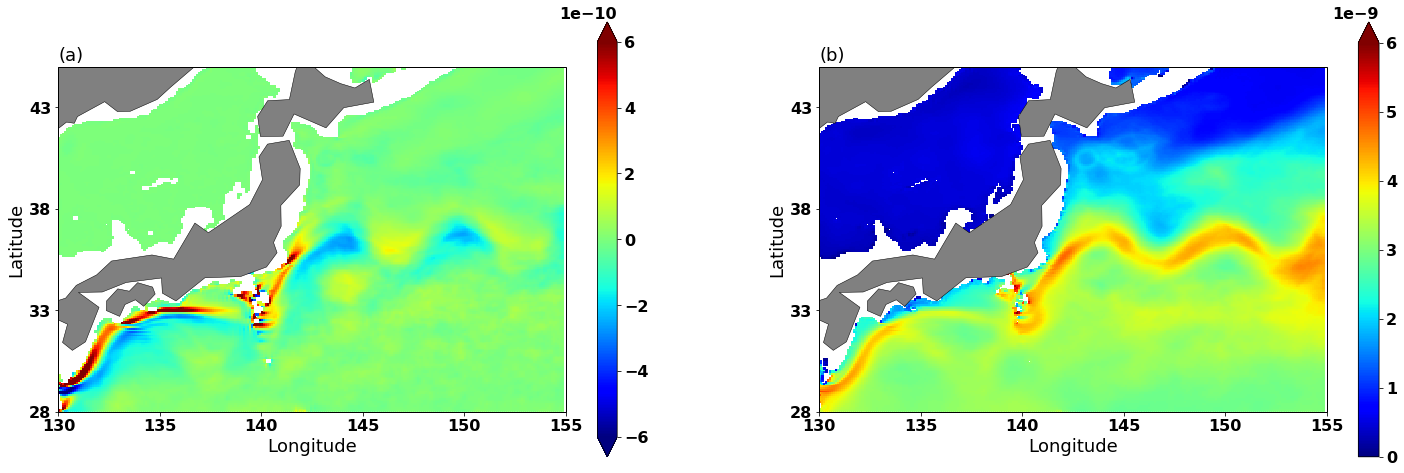

In [12]:
fig=plt.figure(figsize=(25,8))
d=400
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p3=RealRV.sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=True,vmin=-6e-10,vmax=6e-10)
#ax3 = plt.axes([0.93,0.25,0.01,0.5])
#cb3=plt.colorbar(p3)#,cax=ax3)
#cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
#ax0.set_aspect('auto')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)


ax0=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p4=Planetary.sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=True,vmin=0,vmax=6e-09,)
#ax0.set_aspect('auto')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)
#ax4 = plt.axes([0.93,0.25,0.01,0.5])
#cb4=plt.colorbar(p4,cax=ax4)#,cax=ax4)
#cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
#savefigure('rvandrho')

RV: year-mean relative vorticity: $\overline{\zeta} =\overline{ -\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}}$ <br>
buofre: year-mean vertical density gradient $\overline{\frac{\partial \rho}{\partial z}}$ <br>
PV:year-mean vertical potential vorticity (computed with velocities and density)$\overline{-\frac{g}{\rho_0}(f+\zeta)\frac{\partial \rho}{\partial z}}$

In [70]:
# save 1999-2009 pv_separation
RV.to_netcdf('RV10yrmean_Ksh.nc')
buofre.to_netcdf('buofre10yrmean_Ksh.nc')
PV.to_netcdf('reproducedPV10yrmean_Ksh.nc')

## plot part of potential vorticity vs model diag for 1999-2009

In [13]:
pv=cc.querying.getvar(expt,'vert_pv',session,
                     n=n_files,offset=offset)\
                     .sel(xt_ocean=wbcx)\
                     .sel(yt_ocean=wbcy)\
                     .sel(time=time).mean('time')

In [14]:
pv['LON']=pv['xt_ocean']+360

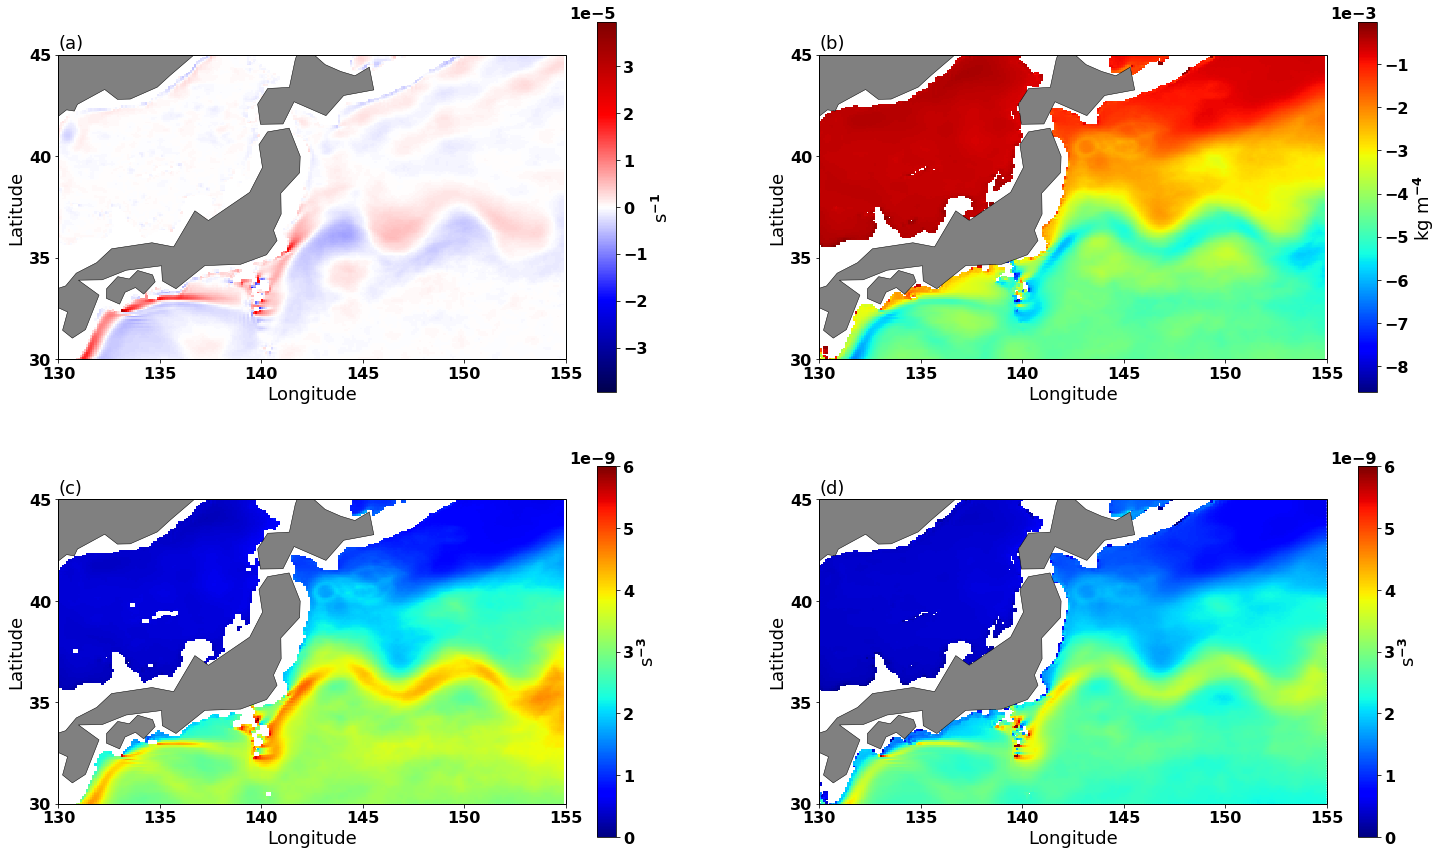

In [15]:
d=400
fig=plt.figure(figsize=(25,15))
ax0=fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
ax0.set_extent([130-360,155-360, 30,45], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([130,135,140,145,150,155], crs=ccrs.PlateCarree())
ax0.set_yticks([30,35,40,45], crs=ccrs.PlateCarree())
p1=RV.sel(st_ocean=d,method='nearest').plot(cmap='seismic',add_colorbar=False)
#ax1 = plt.axes([0.93,0.25,0.01,0.5])
cb1=plt.colorbar(p1)#,cax=ax1)
cb1.formatter.set_powerlimits((0, 0))
cb1.update_ticks()
cb1.ax.set_ylabel('s$^{-1}$',fontsize=18)
#ax0.set_aspect('auto')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

ax0=fig.add_subplot(2,2,2,projection=ccrs.PlateCarree())
ax0.set_extent([130-360,155-360, 30,45], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([130,135,140,145,150,155], crs=ccrs.PlateCarree())
ax0.set_yticks([30,35,40,45], crs=ccrs.PlateCarree())
p2=buofre.sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=False)
#ax2 = plt.axes([0.93,0.25,0.01,0.5])
cb2=plt.colorbar(p2)#,cax=ax2)
cb2.ax.set_ylabel('kg m$^{-4}$',fontsize=18)
#ax0.set_aspect('auto')
cb2.formatter.set_powerlimits((0, 0))
cb2.update_ticks()
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,3,projection=ccrs.PlateCarree())
ax0.set_extent([130-360,155-360, 30,45], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([130,135,140,145,150,155], crs=ccrs.PlateCarree())
ax0.set_yticks([30,35,40,45], crs=ccrs.PlateCarree())
p3=PV.sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=False,vmin=0,vmax=6e-09)
#ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb3=plt.colorbar(p3)#,cax=ax3)
cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
#ax0.set_aspect('auto')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,4,projection=ccrs.PlateCarree())
ax0.set_extent([130-360,155-360, 30,45], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([130,135,140,145,150,155], crs=ccrs.PlateCarree())
ax0.set_yticks([30,35,40,45], crs=ccrs.PlateCarree())
p4=pv.sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=False,vmin=0,vmax=6e-09,)
#ax4 = plt.axes([0.93,0.25,0.01,0.5])
cb4=plt.colorbar(p4)#,cax=ax4)
cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
#ax0.set_aspect('auto')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('')
plt.title('(d)',loc='left',fontsize=18)
savefigure('pv_sep_Ksh')